This notebook evaluates data points in a single dataset by removing duplicates and .

For first round cleaning, the input dataset should have the following columns:

- `FACILITY_NAME`: facility name
- `CLEAN_NAME`: cleaned facility name
- `CLUSTER1`: feature sequence (found using a 100m radius)
- `DATE`: date
- `FACILITY_TYPE`: facility type 

Steps:

1. obtain subclusters, data points whose cleaned facility names are matched to the same name via a fuzzy match and whose facility types are the same. Each point is assigned a clusterID: CLUSTER1-name_seq-type_seq.

2. calculate cluster ratio using subcluster size/cluster size.

3. evaluate points based on cluster size and cluster ratio. The output column is `EVAL1`. Possible values are 0 (bad), 1 (good), 2 (evaluate).
    - N=1: -> 2(evaluate).
    - N=2: if two points agree -> 1(good), otherwise -> 2(evaluate).
    - N=3: if cluster ratio > 0.66 -> 1(good), otherwise -> 2(evaluate).
    - N=4: if every point disagrees (i.e. there are 4 subclusters) -> 2(evaluate). 
      Otherwise, look at cluster ratio: less than or equal to 0.2 -> 0(bad), between 0.2 and 0.5 -> 2(evaluate), greater than or equal to 0.5 -> 1(good).
    - N>=5: just look at cluster ratio: less than or equal to 0.2 -> 0(bad), between 0.2 and 0.5 -> 2(evaluate), greater than or equal to 0.5 -> 1(good).
    
4. remove points. 
    - drop points where `EVAL1` = 0(bad).
    - for each subcluster, only keep the most recent entry (values sorted by date).

For second round cleaning, the input dataset should have the following columns:

- `CLUSTER2`: feature sequence (found using a 1km radius and match name)
- `EVAL1`: evaluation column from first round cleaning

For each cluster, look at values of `EVAL1`, now possible values are 1 (good), 2 (evaluate). The new output column is `EVAL2`. Possible values are 0 (bad), 1 (good).

- Both types exist.
    - For points with `EVAL1`=1, only keep the one with the maximum subcluster size -> 1(good). All other points -> 0(bad).
    - For points with `EVAL1`=2 -> 0(bad).

- Only one type of points exists.
    - Points with the maximum subcluster size -> 1(good).
    - All other points -> 0(bad).

There are 4 resulting files:

- `decision1`: data with 1st round evaluation. The number of data points is the same as the original dataset. The evaluation column is defined using `EVAL1`
- `dropped1`: data after dropping points based on first round evaluation.
- `decision2`: data with 2nd round evaluation. The number of data points is the same as `dropped1`. The evaluation column is defined using `EVAL2`
- `dropped2`: data after dropping points based on second round evaluation. 

In [3]:
import numpy as np
import pandas as pd
import fiona
import geopandas as gpd
import os
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [4]:
# IMPORT DATASET AS df

# data import
dataDir = r"C:\Users\DUANYUEYUN\Documents\ArcGIS\Projects\WHO_ISS"
df = gpd.read_file(dataDir+"\\WHO_ISS.gdb", driver='FileGDB', layer= 'ISS_1020')
dataDir = r"C:\Users\DUANYUEYUN\Documents\GRID3\Health facilities\Data\Africa\Cleaned"
filename = "clean_names_types_1109.csv"
path = os.path.join(dataDir, filename)
new_cols = pd.read_csv(path)
# get index
df.reset_index(inplace=True)
# merge with new columns including 'clean_name_final'
df = df.merge(new_cols, on='index')
df = df[df['Country']=='DEMOCRATIC REPUBLIC OF THE CONGO']

In [5]:
# INPUT
FACILITY_NAME = 'clean_name'
CLEAN_NAME = 'clean_name_final'
CLUSTER1 = 'FEAT_SEQ'
CLUSTER2 = 'FEAT_SEQ'
DATE = 'date_of_visit'
FACILITY_TYPE = 'type_of_facility_visited'

# PARAMETERS
# match score thresholds for two names to be considered a match
SIMPLE_SCORE, SIMPLE_SCORE_MIN, PARTIAL_SCORE, PARTIAL_SCORE2 =80, 50, 80, 90

# OUTPUT COLUMNS
EVAL1 = 'eval'
EVAL2 = 'eval2'

# path to save results
SAVE_PATH = r"C:\Users\DUANYUEYUN\Documents\GRID3\Health facilities\Data\Africa"
# resulting file names
decision1 = "decisions1.csv"
dropped1 = "results1.csv"
decision2 = "decision2.csv"
dropped2 = "results2.csv"

# Define functions

In [6]:
def find_subclusters(df, name, clean_name, cluster, date, fac_type,
                     simple_score=80, simple_score_min=50, 
                     partial_score=80, partial_score2=90):
    """
    Obtain subclusters: data points within 100m, matched to the same name and have the same facility type.
    """
    
    # reformat the date column
    df[date] = pd.to_datetime(df[date])
    
    # if the cleaned short name is missing, just use original facility name instead
    names = []
    for idx, row in df.iterrows():
        if isinstance(row[clean_name], str):
            names.append(row[clean_name])
        else:
            names.append(row[name])
    df['name_for_matching'] = names 
    # replace the missing values with 'NA'
    df['name_for_matching'].fillna('NA', inplace=True)
    
    # sort values based on feature sequence, name_for_matching and date
    df.sort_values(by=[cluster, 'name_for_matching', date], inplace=True)
    # group by feature sequence
    df_grouped = df.groupby(cluster)

    # store the matched name
    match_names = []
    # store count of subclusters
    sub_counts = []
    # store score of matching
    match_scores = []
    # store types of matching
    match_types = []

    for group_name, df_group in df_grouped:
        # obtain list of names in a cluster
        names = df_group['name_for_matching'].to_list()
        
        # use the first name as the potential candidate for finding a match
        match_candidates = [names[0]]
        match_names.append(names[0])
        match_scores.append(np.nan)
        match_types.append('Self')

        # for the remaining names
        for i in range(1, len(names)):
            # get the facility name to be matched
            name = names[i]

            # use match candidates to find best match and compute match score
            match_name1, score1 = process.extractOne(name, match_candidates, scorer = fuzz.ratio)
            match_name2, score2 = process.extractOne(name, match_candidates, scorer = fuzz.partial_ratio)

            # score based on simple ratio
            # or for very short strings, a single letter difference will result in low score
            # consider two short strings as a match if there's only 1 letter difference
            if score1>=simple_score or (1-score1/100) * len(name) <= 1:
                # append match name and score
                match_names.append(match_name1)
                match_scores.append(score1)
                match_types.append('Simple match')

            # if simple ratio not that high, check partial ratio
            elif score1>=simple_score_min and score2>=partial_score:
                # append match name and score
                match_names.append(match_name2)
                match_scores.append(score2)
                match_types.append('Partial match')

            elif score1>=simple_score_min:
                # check scores again after sorting the letters in names individually
                match_candidates2 = [''.join(sorted(candidate)) for candidate in match_candidates]
                match_name3, score3 = process.extractOne(''.join(sorted(name)), match_candidates2, 
                                                         scorer = fuzz.ratio)
                match_name4, score4 = process.extractOne(''.join(sorted(name)), match_candidates2, 
                                                         scorer = fuzz.partial_ratio)

                # or for very short strings, a single letter difference will result in low score
                # consider two short strings as a match if there's only 1 letter difference
                if score3>=simple_score or (1-score3/100) * len(name) <= 1:
                    # append match name and score
                    index = match_candidates2.index(match_name3)
                    match_names.append(match_candidates[index])
                    match_scores.append(score3)
                    match_types.append('Sorted simple match')

                # if simple ratio not that high, check partial ratio
                elif score3>=simple_score_min and score4>=partial_score2:
                    # append match name and score
                    index = match_candidates2.index(match_name4)
                    match_names.append(match_candidates[index])
                    match_scores.append(score4)
                    match_types.append('Sorted partial match')

                # if nothing above works, add the name to match candidates
                else:
                    match_candidates.append(name)
                    match_names.append(name)
                    match_scores.append(np.nan)
                    match_types.append('Self')

            # the match score based on simple ratio is lower than the minimum required
            # just match the name to itself and add it to match candidates
            else:
                match_candidates.append(name)
                match_names.append(name)
                match_scores.append(np.nan)
                match_types.append('Self')
    
    df['match_name'] = match_names
    df['match_score'] = match_scores
    df['match_type'] = match_types
    
    def rank(s):
        return s.rank(method='dense')
    
    # assign a sub sequence number
    df['name_seq'] = df.groupby(cluster)['match_name'].apply(rank)
    df['name_seq'].fillna(0, inplace=True)
    df['name_seq'] = df['name_seq'].astype('int')
    
    df['type_seq'] = df.groupby([cluster, 'name_seq'])[fac_type].apply(rank)
    df['type_seq'].fillna(0, inplace=True)
    df['type_seq'] = df['type_seq'].astype('int')
    
    # generate cluster ID
    df['clusterID'] = df[cluster].astype('str').str.cat([df['name_seq'].astype('str'),
                                                        df['type_seq'].astype('str')], sep='-')
    # sort by subcluster
    df.sort_values(by=[cluster, 'name_seq', 'type_seq'], inplace=True)

In [7]:
def cal_cluster_ratio(df, subcluster=['FEAT_SEQ','name_seq','type_seq'], 
                      cluster='FEAT_SEQ', clusterID='clusterID', date = 'date'):
    """
    Calculate cluster ratio after fuzzy match.
    """
    # obtain cluster size
    counts = df.groupby(cluster).agg(n_subclusters=(clusterID, 'nunique'),
                                    freq_count=(clusterID, 'count'))
    counts.reset_index(inplace=True)
    # join back to the original dataframe
    df = df.merge(counts, on =[cluster])

    # obtain subcluster size
    res = df.groupby(clusterID)\
    .agg(cluster_size=('freq_count', 'max'), subcluster_size=('freq_count','count'))
    # calculate cluster ratio
    res['cluster_ratio'] = res['subcluster_size']/res['cluster_size']
    res.reset_index(inplace=True)
    
    # join back to original dataframe
    df = df.merge(res, on=clusterID)
    # sort values
    df = df.sort_values(by=subcluster + ['cluster_ratio', date])
    df.drop(columns=['freq_count'], inplace=True)
    
    return df

In [8]:
def eval_points(df, cluster = 'FEAT_SEQ', cluster_size = 'cluster_size', 
                subcluster_size = 'subcluster_size', num_subclusters = 'n_subclusters', 
                ratio = 'cluster_ratio', new_col='eval'):
    """Implement a decision tree to evalute subclusters and create an `eval` column.
    Possible values include 0 (to be dropped), 1 (good point to be kept) and
    2 (point that needs further examination)
    """

    evaluation = []

    # group by cluster
    clusters = df.groupby(cluster)

    for group_name, group_df in clusters:

        # number of points in the cluster
        N = group_df[cluster_size].iloc[0]
        # number of subclusters within the cluster
        m = group_df[num_subclusters].iloc[0]

        # Single point clusters => eval=2
        if N==1:
            evaluation.append(2)

        # Two point clusters
        elif N==2:
            for idx, row in group_df.iterrows():
                # two points agree => eval=1
                if row[ratio]==1:
                    evaluation.append(1)
                # otherwise, eval=2
                else:
                    evaluation.append(2)
                    
        # Three point clusters
        elif N==3:
            for idx, row in group_df.iterrows():
                # for points with ratio >= 2/3, eval=1
                if row[ratio]>0.66:
                    evaluation.append(1)
                # otherwise, eval=2
                else:
                    evaluation.append(2)   
                    
        # Four point clusters
        elif N==4:
            # every point disagrees, eval=2
            if m==4:
                for idx, row in group_df.iterrows():
                    evaluation.append(2)
            
            else:
                for idx, row in group_df.iterrows():
                    # for points with ratio greater than or equal to 0.5, eval=1
                    if row[ratio]>=0.5:
                        evaluation.append(1)
                    # otherwise, discard points, eval=0
                    else:
                        evaluation.append(0)
        # For clusters with size greater than 4
        else:
            for idx, row in group_df.iterrows():
                # for points with ratio smaller than or equal to 0.2, eval=0
                if row[ratio]<=0.2:
                    evaluation.append(0)
                # for points with ratio between 0.2 and 0.5, eval=2
                elif row[ratio]>0.2 and row[ratio]<0.5:
                    evaluation.append(2)
                # for points with ratio greater than or equal to 0.5, eval=1
                else:
                    evaluation.append(1)

    df[new_col] = evaluation     

In [9]:
def drop_points(df, decision = 'eval', clusterID = 'clusterID'):
    """Drop subclusters with eval of 0,
    keep the last point in subclusters with eval of 1 or 2.
    decision: column name that contains evaluation of points."""
    
    df = df[df[decision]!=0]
    
    # keep the most recent entry for each subcluster
    df_dropped = df.drop_duplicates(subset=[clusterID], keep='last')
    
    return df_dropped

In [10]:
def eval_phase2(df, cluster='FEAT_SEQ', decision='eval',
               subcluster_size='subcluster_size', new_decision = 'eval2'):
    
    """Evaluate points within the new cluster.
    0 means drop and 1 means keep.
    decision: column name for first phase evaluation.
    new_decision: column name for second phase evaluation."""
    
    drop = []
    df.sort_values([cluster, decision, subcluster_size], inplace=True)
    df_grouped = df.groupby(cluster)
    
    for name, df_group in df_grouped:
        max_subcluster = df_group[subcluster_size].max()
        
        # There are points with both eval=1 and eval=2 in the cluster
        if df_group[decision].nunique()>1:
            # If there are more than 1 point with eval=1, keep the point with max sublcuster size
            if df_group[df_group[decision]==1].shape[0]>1:
                for idx, row in df_group.iterrows():
                    if row[decision]==1 and row[subcluster_size]==max_subcluster:
                        drop.append(1)
                    # Drop points with eval=2  
                    else:
                        drop.append(0)
            # There is only 1 point with eval=1, just keep that point and drop the rest
            else:
                for idx, row in df_group.iterrows():
                    # Keep only points with eval=1
                    if row[decision]==1:
                        drop.append(1)
                    # Drop points with eval=2  
                    else:
                        drop.append(0)
        # There are either points with eval=1 or points with eval=2 (exclusive)       
        else:
            for idx, row in df_group.iterrows():
                # Keep only points with the maximum subcluster size
                if row[subcluster_size]==max_subcluster:
                    drop.append(1)
                # Drop all other points   
                else:
                    drop.append(0)
                 
    df[new_decision] = drop
    df_dropped = df[df[new_decision]==1]
    
    return df, df_dropped    

# 1st round cleaning

In [37]:
# find subclusters
find_subclusters(df, name=FACILITY_NAME, clean_name=CLEAN_NAME, 
                 date=DATE, cluster=CLUSTER1, fac_type=FACILITY_TYPE,
                simple_score=SIMPLE_SCORE, simple_score_min=SIMPLE_SCORE_MIN, 
                 partial_score=PARTIAL_SCORE, partial_score2=PARTIAL_SCORE2)

# calculate cluster ratio
df_ratio = cal_cluster_ratio(df, subcluster=[CLUSTER1]+['name_seq','type_seq'], 
                      cluster=CLUSTER1, date = DATE)

# evaluate points
eval_points(df_ratio, cluster = CLUSTER1, new_col=EVAL1)

# drop points 
df_dropped = drop_points(df_ratio, decision = EVAL1)

In [41]:
s = df_ratio.groupby(CLUSTER1).size()
s[s==7].head()

FEAT_SEQ
54483    7
54519    7
54530    7
54538    7
54543    7
dtype: int64

In [39]:
cols = ['name_of_facility_visited', 'clean_name_final', 'type_of_facility_visited', 'match_name',
        'FEAT_SEQ', 'clusterID', 'cluster_size', 'subcluster_size', 'cluster_ratio',
       'eval']
df_ratio[df_ratio[CLUSTER1]==54440][cols]

,name_of_facility_visited,clean_name_final,type_of_facility_visited,match_name,FEAT_SEQ,clusterID,cluster_size,subcluster_size,cluster_ratio,eval
38,CS IME Kimpese,Ime Kimpese,CSI,Ime Kimpese,54440,54440-1-1,4,1,0.25,0
39,IME KIMPESE,Ime Kimpese,GENERAL_HOSP,Ime Kimpese,54440,54440-1-2,4,3,0.75,1
40,HGR IME KIMPESE,Ime Kimpese,GENERAL_HOSP,Ime Kimpese,54440,54440-1-2,4,3,0.75,1
41,HGR IME KIMPESE,Ime Kimpese,GENERAL_HOSP,Ime Kimpese,54440,54440-1-2,4,3,0.75,1


In [42]:
df_ratio[df_ratio[CLUSTER1]==54519][cols]

,name_of_facility_visited,clean_name_final,type_of_facility_visited,match_name,FEAT_SEQ,clusterID,cluster_size,subcluster_size,cluster_ratio,eval
301,BEBE BIBI ERIC,Bebe Bibi Eric,CSI,Bebe Bibi Eric,54519,54519-1-1,7,1,0.142857,0
302,CS Monga 1,Monga 1,CSI,Monga 1,54519,54519-2-1,7,6,0.857143,1
303,CS Monga 1,Monga 1,CSI,Monga 1,54519,54519-2-1,7,6,0.857143,1
304,Centre de Santé MONGA 1,Monga 1,CSI,Monga 1,54519,54519-2-1,7,6,0.857143,1
305,Centre de Santé MONGA 1,Monga 1,CSI,Monga 1,54519,54519-2-1,7,6,0.857143,1
306,Centre de Santé MONGA 1,Monga 1,CSI,Monga 1,54519,54519-2-1,7,6,0.857143,1
307,CS Monga 1,Monga 1,CSI,Monga 1,54519,54519-2-1,7,6,0.857143,1


In [40]:
df_ratio[df_ratio[CLUSTER1]==55480][cols]

,name_of_facility_visited,clean_name_final,type_of_facility_visited,match_name,FEAT_SEQ,clusterID,cluster_size,subcluster_size,cluster_ratio,eval
2868,Camp préfabriqué,Camp Prefabrique,CSI,Camp Prefabrique,55480,55480-1-1,10,1,0.1,0
2869,JESUS LE ROC,Jesus Le Roc,PRIVATE_FACILITY,Jesus Le Roc,55480,55480-2-1,10,1,0.1,0
2870,C.S Lorra,Lorra,CSI,Lorra,55480,55480-3-1,10,3,0.3,2
2871,CENTRE DE SANTE LORRA,Lorra,CSI,Lorra,55480,55480-3-1,10,3,0.3,2
2872,LORRA,Lorra,CSI,Lorra,55480,55480-3-1,10,3,0.3,2
2873,LORRA,Lorra,PRIVATE_FACILITY,Lorra,55480,55480-3-2,10,5,0.5,1
2874,LORRA,Lorra,PRIVATE_FACILITY,Lorra,55480,55480-3-2,10,5,0.5,1
2875,CS Lorra,Lorra,PRIVATE_FACILITY,Lorra,55480,55480-3-2,10,5,0.5,1
2876,CS Lorra,Lorra,PRIVATE_FACILITY,Lorra,55480,55480-3-2,10,5,0.5,1
2877,CS Lorra,Lorra,PRIVATE_FACILITY,Lorra,55480,55480-3-2,10,5,0.5,1


## Sanity check

In [27]:
print("Number of subclusters:", df_ratio['clusterID'].nunique())

Number of subclusters: 7448


Text(0.5, 1.0, 'Histogram of cluster ratio')

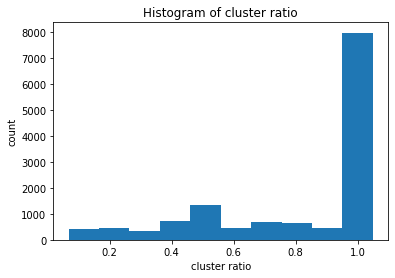

In [28]:
f = plt.hist(df_ratio['cluster_ratio'], bins=10, align='right')
plt.xlabel('cluster ratio')
plt.ylabel('count')
plt.title('Histogram of cluster ratio')

In [29]:
print("Summary statistics of cluster ratio:")
df_ratio['cluster_ratio'].describe()

Summary statistics of cluster ratio:


count    13508.000000
mean         0.788644
std          0.292394
min          0.018182
25%          0.545455
50%          1.000000
75%          1.000000
max          1.000000
Name: cluster_ratio, dtype: float64

In [30]:
print("Value counts of first evaluation:")
df_ratio[EVAL1].value_counts(sort=False)

Value counts of first evaluation:


0    1017
1    7509
2    4982
Name: eval, dtype: int64

In [31]:
print("Number of data points before:", df.shape[0])
print("Number of data points after dropping:", df.shape[0]-df_dropped.shape[0])

Number of data points before: 13508
Number of data points after dropping: 6912


In [32]:
# rename columns and reset index
df_ratio.rename(columns={'index':'index_original', CLUSTER1:'Cluster_seq1'},
                   inplace=True)
df_ratio.reset_index(drop=True,inplace=True)
df_dropped.rename(columns={'index':'index_original', CLUSTER1:'Cluster_seq1'},
                   inplace=True)
df_dropped.reset_index(drop=True,inplace=True)

In [25]:
# Export results as csv files
df_ratio.to_csv(os.path.join(SAVE_PATH, decision1), index=False)
df_dropped.to_csv(os.path.join(SAVE_PATH, dropped1), index=False)

# 2nd round cleaning

Starting from here, points with `EVAL1` of 0 in the first phase are dropped and duplicates within subclusters with `eval` of 1 or 2 are also dropped such that there is only one point representing each subcluster.

A new feature sequence is found using a radius of 1km and a match on `match_name`.

In [43]:
# Data import
dataDir = r"C:\Users\DUANYUEYUN\Documents\GRID3\Health facilities\Data\Africa"
df_dropped1 = pd.read_csv(dataDir + "\\Cleaned\\iss_dropped1_1203.csv")
dataDir2 = r"C:\Users\DUANYUEYUN\Documents\ArcGIS\Projects\WHO_ISS"
feat_seq = gpd.read_file(dataDir2+"\\WHO_ISS.gdb", driver='FileGDB', 
                       layer= 'iss_dropped1_1203_FI')
feat_seq = feat_seq.sort_values(by=['IN_FID', 'FEAT_SEQ'])\
.drop_duplicates(subset='IN_FID', keep='first')
feat_seq['IN_FID'] = feat_seq['IN_FID']-1
# add feature sequence to original dataset
df_dropped1 = df_dropped1.merge(feat_seq.drop(columns=['geometry']), left_index=True, right_on='IN_FID')
df_dropped1 = df_dropped1[df_dropped1['Country']=='DEMOCRATIC REPUBLIC OF THE CONGO']

C:\Users\DUANYUEYUN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (13,20,24,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
print("Number of data points:", df_dropped1.shape[0])
print("Number of clusters:", df_dropped1['FEAT_SEQ'].nunique())

Number of data points: 6592
Number of clusters: 5835


In [45]:
df_decision2, df_dropped2 = eval_phase2(df_dropped1, cluster=CLUSTER2, 
                                        decision=EVAL1, new_decision = EVAL2)

In [46]:
print("Number of points before:", df_dropped1.shape[0])
print("Number of points after:", df_dropped2.shape[0])

Number of points before: 6592
Number of points after: 6181


In [64]:
cols = ['name_of_facility_visited', 'clean_name_final', 'type_of_facility_visited', 'match_name',
        'FEAT_SEQ', 'clusterID', 'subcluster_size', 'cluster_ratio',
       'eval', 'eval2']
df_decision2[df_decision2[CLUSTER2]==51122][cols]

,name_of_facility_visited,clean_name_final,type_of_facility_visited,match_name,FEAT_SEQ,clusterID,subcluster_size,cluster_ratio,eval,eval2
61759,Hgr kinkole,Kinkole,GENERAL_HOSP,Kinkole,51122,5.452500e+09,17,1.0,1,1
61765,Hgr kinkole,Kinkole,GENERAL_HOSP,Kinkole,51122,5.667400e+09,1,1.0,2,0
61764,Hgr kinkole,Kinkole,GENERAL_HOSP,Kinkole,51122,5.668600e+09,1,1.0,2,0
61763,Hgr kinkole,Kinkole,GENERAL_HOSP,Kinkole,51122,5.875000e+09,1,1.0,2,0
61762,Hgr kinkole,Kinkole,GENERAL_HOSP,Kinkole,51122,5.876500e+09,1,1.0,2,0
61761,Hgr kinkole,Kinkole,GENERAL_HOSP,Kinkole,51122,5.878000e+09,1,1.0,2,0
61760,Hgr kinkole,Kinkole,GENERAL_HOSP,Kinkole,51122,5.879700e+09,1,1.0,2,0


In [65]:
df_decision2[df_decision2[CLUSTER2]==52683][cols]

,name_of_facility_visited,clean_name_final,type_of_facility_visited,match_name,FEAT_SEQ,clusterID,subcluster_size,cluster_ratio,eval,eval2
63565,CH Émeraude,Emeraude,PRIVATE_FACILITY,Emeraude,52683,5.665300e+09,2,1.000000,1,0
63564,CH Émeraude 2,Emeraude 2,PRIVATE_FACILITY,Emeraude,52683,5.667200e+09,2,1.000000,1,0
63563,Émeraude,Emeraude,PRIVATE_FACILITY,Emeraude,52683,5.875800e+09,2,1.000000,1,0
63560,CH Émeraude 2,Emeraude 2,PRIVATE_FACILITY,Emeraude,52683,5.596900e+09,11,0.785714,1,1
63562,CH Émeraude,Emeraude,PRIVATE_FACILITY,Emeraude,52683,5.879500e+09,1,1.000000,2,0
63561,Émeraude,Emeraude,PRIVATE_FACILITY,Emeraude,52683,5.921000e+09,1,1.000000,2,0


In [66]:
# rename columns and reset index
df_decision2.rename(columns={'FEAT_SEQ':'Cluster_seq2'}, inplace=True)
df_decision2.reset_index(drop=True, inplace=True)
df_dropped2.rename(columns={'FEAT_SEQ':'Cluster_seq2'}, inplace=True)
df_dropped2.reset_index(drop=True, inplace=True)

In [48]:
# export results
df_decision2.to_csv(os.path.join(SAVE_PATH, decision2),index=False)
df_dropped2.to_csv(os.path.join(SAVE_PATH, dropped2),index=False)